In [125]:
import pickle
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
import os.path


#Preprocessing


In [126]:
df = read_csv(data)

#The images are represented in our dataframe as a bunch of text pixel values - make them numpy arrays
df['Image'] = df['Image'].apply(lambda image : np.fromstring(image, sep = ' '))


In [328]:
df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,"[238.0, 236.0, 237.0, 238.0, 240.0, 240.0, 239..."
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,"[219.0, 215.0, 204.0, 196.0, 204.0, 211.0, 212..."
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,"[144.0, 142.0, 159.0, 180.0, 188.0, 188.0, 184..."
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,"[193.0, 192.0, 193.0, 194.0, 194.0, 194.0, 193..."
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,"[147.0, 148.0, 160.0, 196.0, 215.0, 214.0, 216..."


In [128]:
df.dropna(inplace=True)

In [129]:
print df.count()

left_eye_center_x            2140
left_eye_center_y            2140
right_eye_center_x           2140
right_eye_center_y           2140
left_eye_inner_corner_x      2140
left_eye_inner_corner_y      2140
left_eye_outer_corner_x      2140
left_eye_outer_corner_y      2140
right_eye_inner_corner_x     2140
right_eye_inner_corner_y     2140
right_eye_outer_corner_x     2140
right_eye_outer_corner_y     2140
left_eyebrow_inner_end_x     2140
left_eyebrow_inner_end_y     2140
left_eyebrow_outer_end_x     2140
left_eyebrow_outer_end_y     2140
right_eyebrow_inner_end_x    2140
right_eyebrow_inner_end_y    2140
right_eyebrow_outer_end_x    2140
right_eyebrow_outer_end_y    2140
nose_tip_x                   2140
nose_tip_y                   2140
mouth_left_corner_x          2140
mouth_left_corner_y          2140
mouth_right_corner_x         2140
mouth_right_corner_y         2140
mouth_center_top_lip_x       2140
mouth_center_top_lip_y       2140
mouth_center_bottom_lip_x    2140
mouth_center_b

In [130]:
#Get the inputs and outputs
X = np.vstack(df['Image'].values)
X=X.astype(np.float32)
y = df[df.columns[:-1]].values 
X = X / 255.# will scale our pixel inputs to [0, 1]
y = (y - 48) / 48# will scale our coordinate outputs to [-1, 1]
X, y = shuffle(X, y, random_state=65539) #Shuffle our data
y = y.astype(np.float32)

In [131]:
print("X.shape \t X.min \t X.max \t\n{} \t {:.3f}\t {:.3f}\t\n".format(X.shape, X.min(), X.max()))
print("y.shape \t y.min \t y.max \t\n{} \t {:.3f}\t {:.3f}\t\n".format(y.shape, y.min(), y.max()))

X.shape 	 X.min 	 X.max 	
(2140L, 9216L) 	 0.000	 1.000	

y.shape 	 y.min 	 y.max 	
(2140L, 30L) 	 -0.920	 0.996	



### Neural Network #1: 

  >- Missing values are dropped leaving us with roughtly 30% of the original data. Because there are 9216 inputs and only 2140 samples, overfitting may be an issue.
  
  >- Neural Network with one hidden layer
  
  >-[modified from daniel nouri's tutorial](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/#first-model-a-single-hidden-layer)


In [141]:
conv_net = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 9216),  # 96x96 input pixels per image
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  #  15 (x,y) coordinate pairs
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.8,
    regression=True,
    max_epochs=1000, #Run 1000 times through the network
    eval_size=0.2, #20% of our data used for validation
    verbose=1)

conv_net.fit(X, y)

  InputLayer        	(None, 9216)        	produces    9216 outputs
  DenseLayer        	(None, 100)         	produces     100 outputs
  DenseLayer        	(None, 30)          	produces      30 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.161628  |    0.056063  |     2.882954  |             |  0.7s
     2  |    0.041261  |    0.025944  |     1.590365  |             |  0.7s
     3  |    0.021912  |    0.016019  |     1.367835  |             |  0.5s
     4  |    0.015953  |    0.013312  |     1.198409  |             |  0.5s
     5  |    0.014148  |    0.012444  |     1.136968  |             |  0.7s
     6  |    0.013382  |    0.012005  |     1.114693  |             |  0.5s
     7  |    0.012897  |    0.011700  |     1.102251  |             |  0.7s
     8  |    0.012515  |    0.011450  |     1.092995  |             |  0.5s
     9  |    0.012184  |    0.011221  

NeuralNet(X_tensor_type=<function matrix at 0x000000002429E198>,
     batch_iterator_test=<nolearn.lasagne.BatchIterator object at 0x000000001ECC6518>,
     batch_iterator_train=<nolearn.lasagne.BatchIterator object at 0x000000001ECC64E0>,
     eval_size=0.2, hidden_num_units=100, input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=<function mse at 0x000000001ECB2DD8>, max_epochs=1000,
     more_params={}, on_epoch_finished=(), on_training_finished=(),
     output_nonlinearity=None, output_num_units=30, regression=True,
     update=<function nesterov_momentum at 0x000000001ECB6198>,
     update_learning_rate=0.01, update_momentum=0.8,
     use_label_encoder=False, verbose=1,
     y_tensor_type=TensorType(float32, matrix))

In [142]:
import matplotlib.pyplot as plt
%matplotlib inline

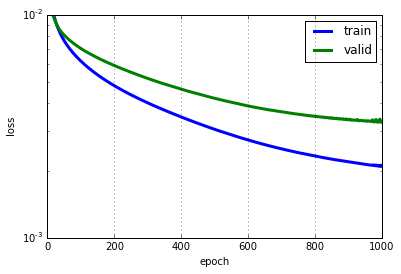

In [144]:
train_loss = np.array([i["train_loss"] for i in conv_net.train_history_])
valid_loss = np.array([i["valid_loss"] for i in conv_net.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3, 1e-2)
plt.yscale("log")
plt.show()

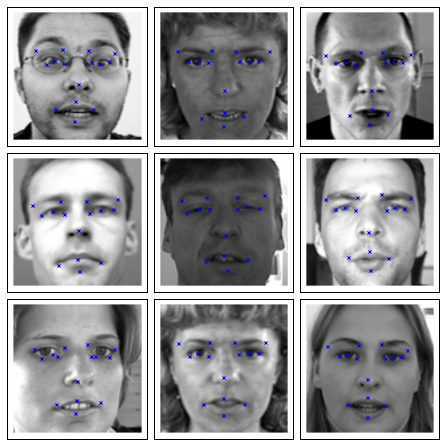

In [478]:
from matplotlib import pyplot

def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

testdf = read_csv('./data/test.csv')
testdf['Image'] = testdf['Image'].apply(lambda image : np.fromstring(image, sep=' '))
X = testdf['Image'].values / 255.
X_test = np.vstack(X)
X_test = X_test.astype(np.float32)
y_pred = net1.predict(X_test)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(3,3, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

plt.show()


Next step - http://yann.lecun.com/exdb/lenet/ CNN with multiple convolution and pooled layers!

In [261]:
sample_sub = read_csv('./data/facial_samplesubmission.csv')
facial_id2 = read_csv('./data/facial_idlookuptable.csv')
facial_id2.head(100)

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
5,6,1,left_eye_inner_corner_y,NaN
6,7,1,left_eye_outer_corner_x,NaN
7,8,1,left_eye_outer_corner_y,NaN
8,9,1,right_eye_inner_corner_x,NaN
9,10,1,right_eye_inner_corner_y,NaN


In [196]:
FeatureNames = np.unique(facial_id.FeatureName)

In [203]:
features = {}
for x, feature in enumerate(FeatureNames):
    features[str(feature)] = x

In [262]:
FeatureNames

array(['left_eye_center_x', 'left_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_left_corner_x',
       'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'nose_tip_x', 'nose_tip_y',
       'right_eye_center_x', 'right_eye_center_y',
       'right_eye_inner_corner_x', 'right_eye_inner_corner_y',
       'right_eye_outer_corner_x', 'right_eye_outer_corner_y',
       'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y',
       'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y'], dtype=object)

In [212]:
y_pred[0][features['nose_tip_x']]

-0.66172200361749633

In [214]:
facial_id.head(1)

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN


In [479]:
for y in y_pred[:5]:
    print len(y)

30
30
30
30
30


In [480]:
y_pred[:][0,0]

0.35801366096910414

In [378]:
predictions = [y_pred[i][x] for x in [facial_id[facial_id.ImageId == i].FeatureName] for i in range(len(np.unique(facial_id.ImageId)))] 

In [385]:
predictions = [y_pred[x] [facial_id[facial_id.ImageId == x].FeatureName] for x in np.unique(facial_id.ImageId)]



In [396]:
y_pred.shape

(1783L, 30L)

In [397]:
facial_id.shape

(27124, 4)

In [402]:
np.unique(facial_id.ImageId).shape

(1783L,)

In [403]:
np.unique(facial_id.RowId)

array([    1,     2,     3, ..., 27122, 27123, 27124], dtype=int64)

In [481]:
facial_id.FeatureName
y_pred = (y_pred *48) + 48
preds = [y_pred[x][facial_id[facial_id.ImageId == x].FeatureName] for x in np.unique(facial_id.ImageId)]


In [482]:
x=np.array(preds)

array([ array([ 65.18465573,  38.44648852,  30.91857634,  35.73421442,
        59.08663167,  37.48600575,  72.50661012,  36.40425262,
        37.70808894,  38.35832481,  25.22836675,  38.62522908,
        56.99334669,  28.5126126 ,  76.54363961,  30.78898696,
        37.30806752,  27.31323709,  16.23734383,  28.21644635,
        49.08619308,  53.9373116 ,  60.29099096,  73.14293349,
        31.96798367,  72.75851919,  47.08791725,  67.05863517,
        46.40750657,  81.85546694]),
       array([ 67.92627922,  37.01127747,  29.48022983,  37.17112643,
        59.90581376,  36.86813417,  74.92170259,  36.2048285 ,
        36.43088331,  37.27534324,  21.37938541,  36.81437795,
        57.01372682,  28.86474285,  82.69915702,  28.97953163,
        38.8051482 ,  28.31424673,  13.38905505,  29.01303827,
        48.9068569 ,  58.47548018,  63.49873698,  78.05550821,
        31.08680714,  79.43838076,  48.94334817,  75.07912957,
        47.92285694,  85.4564942 ]),
       array([ 65.94992187,  

In [486]:
z=[]
for y in x:
    for a in y:
        z.append(a)

In [489]:
np.array(z).min()

3.8030043045102389

In [490]:
facial_id.Location = z

In [458]:
import pandas as pd

In [492]:
facial_id.describe()

,RowId,ImageId,FeatureName,Location
count,27124.000000,27124.000000,27124.000000,27124.000000
mean,13562.500000,607.372880,13.964533,48.622484
std,7830.168687,492.180504,9.941828,17.844027
min,1.000000,0.000000,0.000000,3.803004
25%,6781.750000,226.000000,3.000000,35.271158
50%,13562.500000,453.000000,14.000000,45.366004
75%,20343.250000,935.000000,22.000000,62.589462
max,27124.000000,1782.000000,29.000000,101.628231


In [507]:
with open("submissions.csv", "wb") as f:
    f.write(facial_id[['RowId', 'Location']].to_csv(index=False))

In [501]:
e = facial_id[facial_id.Location >96]

In [502]:
e.Location = 96

In [506]:
facial_id[facial_id.Location <0]

,RowId,ImageId,FeatureName,Location


In [ ]:
facial

In [322]:
y_pred

array([[  3.58013661e-01,  -1.99031489e-01,  -3.55862993e-01, ...,
          3.97054899e-01,  -3.31769466e-02,   7.05322228e-01],
       [  4.15130817e-01,  -2.28931719e-01,  -3.85828545e-01, ...,
          5.64148533e-01,  -1.60714704e-03,   7.80343629e-01],
       [  3.73956706e-01,  -2.21865057e-01,  -3.77316504e-01, ...,
          5.12913526e-01,  -1.38132195e-05,   7.58702052e-01],
       ..., 
       [  3.85065312e-01,  -2.33263694e-01,  -3.92434365e-01, ...,
          5.05589383e-01,  -4.21077996e-02,   7.25035534e-01],
       [  3.14745920e-01,  -2.43254144e-01,  -4.02371588e-01, ...,
          4.47828032e-01,  -1.47865424e-02,   6.94749519e-01],
       [  3.30884054e-01,  -1.90615311e-01,  -3.40730998e-01, ...,
          4.78161032e-01,  -1.17400801e-02,   6.75312635e-01]])